<a href="https://colab.research.google.com/github/orlyihan/CNN-Lettuce-NPK-Malnutrition-Detection/blob/main/cnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import math
import random
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint, Callback


extract_path = '/content'

# Check the extracted structure
print("Train folders:", os.listdir(os.path.join(extract_path, '/content/drive/MyDrive/KaggleNPKDataset2/train')))
print("Validation folders:", os.listdir(os.path.join(extract_path, '/content/drive/MyDrive/KaggleNPKDataset2/valid')))
print("Test folders:", os.listdir(os.path.join(extract_path, '/content/drive/MyDrive/KaggleNPKDataset2/test')))


Train folders: ['P', 'N', 'FN', 'K']
Validation folders: ['N', 'P', 'FN', 'K']
Test folders: ['N', 'P', 'FN', 'K']


In [ ]:
# Set the seed value for reproducibility
seed_value = 42

# Seed Python's random module
random.seed(seed_value)

# Seed NumPy
np.random.seed(seed_value)

# Set the TensorFlow random seed
tf.random.set_seed(seed_value)


# Initialize ImageDataGenerators
#image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)


valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Directory paths
train_dir = '/content/drive/MyDrive/KaggleNPKDataset2/train'
valid_dir = '/content/drive/MyDrive/KaggleNPKDataset2/valid'
test_dir = '/content/drive/MyDrive/KaggleNPKDataset2/test'

# Flow from directory for each set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical'
)

print("\nFiles in training directory:", os.listdir(train_dir))

# Check the number of samples in each class
for class_name in os.listdir(train_dir):
  class_path = os.path.join(train_dir, class_name)
  print(f"Class '{class_name}': {len(os.listdir(class_path))} samples\n")

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical'
)

print("\nFiles in validation directory:", os.listdir(valid_dir))

# Check the number of samples in each class
for class_name in os.listdir(valid_dir):
  class_path = os.path.join(valid_dir, class_name)
  print(f"Class '{class_name}': {len(os.listdir(class_path))} samples\n")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

print("\nFiles in test directory:", os.listdir(test_dir))

# Check the number of samples in each class
for class_name in os.listdir(test_dir):
  class_path = os.path.join(test_dir, class_name)
  print(f"Class '{class_name}': {len(os.listdir(class_path))} samples\n")


Found 1602 images belonging to 4 classes.

Files in training directory: ['P', 'N', 'FN', 'K']
Class 'P': 234 samples

Class 'N': 517 samples

Class 'FN': 175 samples

Class 'K': 676 samples

Found 271 images belonging to 4 classes.

Files in validation directory: ['N', 'P', 'FN', 'K']
Class 'N': 77 samples

Class 'P': 36 samples

Class 'FN': 29 samples

Class 'K': 129 samples

Found 215 images belonging to 4 classes.

Files in test directory: ['N', 'P', 'FN', 'K']
Class 'N': 77 samples

Class 'P': 21 samples

Class 'FN': 32 samples

Class 'K': 85 samples



In [ ]:
# Model setup with InceptionResNetV2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


1

In [ ]:
# Set batch size
batch_size = 8

# Calculate steps per epoch
steps_per_epoch = math.ceil((train_generator.samples) / batch_size)
validation_steps = math.ceil((valid_generator.samples) / batch_size)

# Configure callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

class SaveCheckpointEveryNEpochs(Callback):
    def __init__(self, filepath, save_freq=10):
        super(SaveCheckpointEveryNEpochs, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.filepath.format(epoch=epoch + 1)
            self.model.save(filepath)
            print(f"\nCheckpoint saved at {filepath}")

# Initialize custom checkpoint callback
custom_checkpoint_callback = SaveCheckpointEveryNEpochs(
    filepath='checkpoint_epoch_{epoch}.keras',
    save_freq=10
)

# Update the model fit with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, custom_checkpoint_callback]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/201 ━━━━━━━━━━━━━━━━━━━━ 5:33 3s/step - accuracy: 0.3429 - loss: 1.3701

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


201/201 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.3835 - loss: 1.3263 - val_accuracy: 0.4576 - val_loss: 1.2370 - learning_rate: 1.0000e-05
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 55s 257ms/step - accuracy: 0.6453 - loss: 1.0308 - val_accuracy: 0.5941 - val_loss: 1.0828 - learning_rate: 1.0000e-05
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 54s 252ms/step - accuracy: 0.7502 - loss: 0.8515 - val_accuracy: 0.6900 - val_loss: 0.9288 - learning_rate: 1.0000e-05
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 54s 254ms/step - accuracy: 0.7734 - loss: 0.7325 - val_accuracy: 0.7048 - val_loss: 0.8652 - learning_rate: 1.0000e-05
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 54s 252ms/step - accuracy: 0.8111 - loss: 0.6420 - val_accuracy: 0.7343 - val_loss: 0.8298 - learning_rate: 1.0000e-05
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 54s 255ms/step - accuracy: 0.8233 - loss: 0.5941 - val_accuracy: 0.7380 - val_loss: 0.7526 - learning_rate: 1.0000e-05
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 54s 254ms/step - ac

In [ ]:
# Unfreeze the last 50 layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='checkpoint_epoch_{epoch}.keras', # Change the file extension to .keras
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Run for a few additional epochs
    validation_data=valid_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
101/201 ━━━━━━━━━━━━━━━━━━━━ 49s 494ms/step - accuracy: 0.7922 - loss: 0.5939
Epoch 1: saving model to checkpoint_epoch_1.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 114s 391ms/step - accuracy: 0.8074 - loss: 0.5748 - val_accuracy: 0.8819 - val_loss: 0.4064 - learning_rate: 1.0000e-06
Epoch 2/10
101/201 ━━━━━━━━━━━━━━━━━━━━ 40s 403ms/step - accuracy: 0.8673 - loss: 0.4569
Epoch 2: saving model to checkpoint_epoch_2.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.8703 - loss: 0.4474 - val_accuracy: 0.8745 - val_loss: 0.4458 - learning_rate: 1.0000e-06
Epoch 3/10
101/201 ━━━━━━━━━━━━━━━━━━━━ 39s 396ms/step - accuracy: 0.9148 - loss: 0.4000
Epoch 3: saving model to checkpoint_epoch_3.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.9094 - loss: 0.4020 - val_accuracy: 0.8708 - val_loss: 0.4669 - learning_rate: 1.0000e-06
Epoch 4/10
101/201 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.8907 - loss: 0.3862
Epoch 4: saving model to checkpoint_epoch_4.keras

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9003 - loss: 0.3219
Test Accuracy: 87.91%
Test Loss: 0.3663


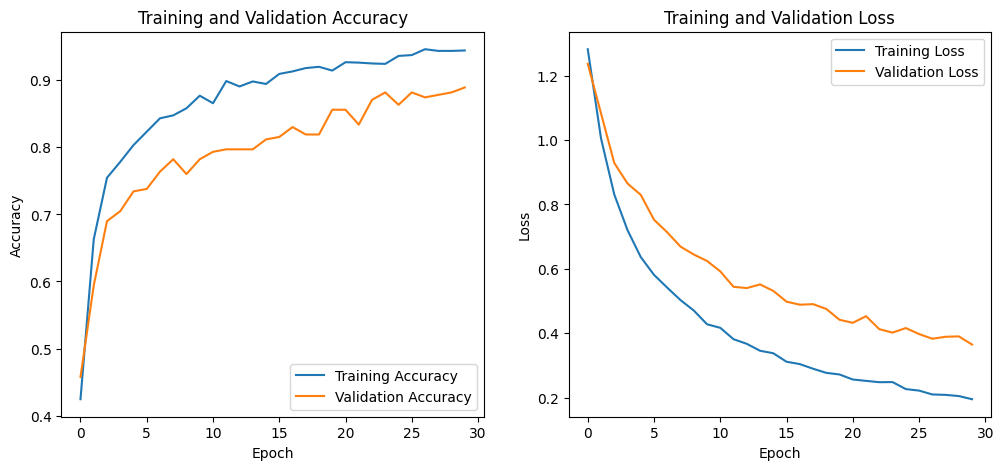

In [ ]:

# Plot accuracy and loss
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)

14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 838ms/step


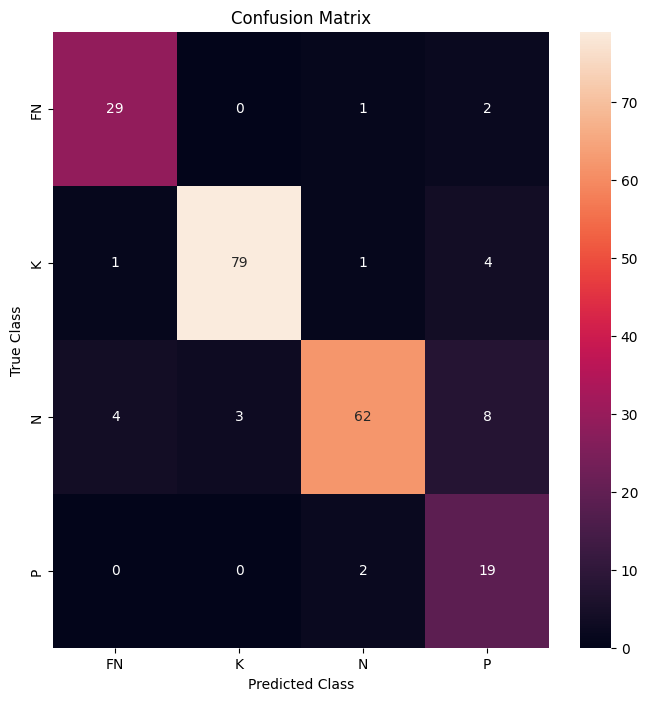

              precision    recall  f1-score   support

          FN       0.85      0.91      0.88        32
           K       0.96      0.93      0.95        85
           N       0.94      0.81      0.87        77
           P       0.58      0.90      0.70        21

    accuracy                           0.88       215
   macro avg       0.83      0.89      0.85       215
weighted avg       0.90      0.88      0.88       215



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and true classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [ ]:
# Predict on test data
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
              precision    recall  f1-score   support

          FN       0.85      0.91      0.88        32
           K       0.96      0.93      0.95        85
           N       0.94      0.81      0.87        77
           P       0.58      0.90      0.70        21

    accuracy                           0.88       215
   macro avg       0.83      0.89      0.85       215
weighted avg       0.90      0.88      0.88       215



Upload an image to test


Saving P (1).png to P (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


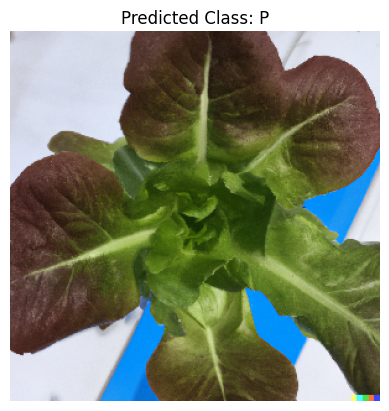

Class Probabilities:
FN: 1.29%
K: 7.12%
N: 6.39%
P: 85.20%


In [ ]:
print("Upload an image to test")
from google.colab import files #Import the files module from google.colab
image_file = files.upload()  # Upload an image
image_path = list(image_file.keys())[0]

from tensorflow.keras.utils import load_img, img_to_array # Import load_img and img_to_array

TARGET_SIZE = (299, 299)  # Change to match the model's input shape
img = load_img(image_path, target_size=TARGET_SIZE)
img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

predictions = model.predict(img_array)
predicted_index = np.argmax(predictions, axis=1)[0]  # Get the class index

# Get class names from the test generator
class_names = list(test_generator.class_indices.keys())

predicted_class = class_names[predicted_index]  # Map index to class name

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

# Additional Debugging: Print probabilities for all classes
print("Class Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {predictions[0][idx] * 100:.2f}%")

In [ ]:
import io
from contextlib import redirect_stdout

summary_text = io.StringIO()
with redirect_stdout(summary_text):
    model.summary()

# Print the summary to easily copy from the output
print(summary_text.getvalue())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 77,670,894 (296.29 MB)

 Trainable params: 10,878,084 (41.50 MB)

 Non-trainable params: 45,036,640 (171.80 MB)

 Optimizer params: 21,756,170 (82.99 MB)

In [ ]:
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))


In [ ]:
from google.colab import files

# Save the model
model.save('npk_malnutrition_model_2.keras')

# Download the saved model
files.download('npk_malnutrition_model_2.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save as HDF5
model.save('npk_malnutrition_model_2.h5')
files.download('npk_malnutrition_model_2.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save as .tflite
with open('npk_malnutrition_model_2.tflite', 'wb') as f:
    f.write(tflite_model)

# Download the TFLite model
files.download('npk_malnutrition_model_2.tflite')


Saved artifact at '/tmp/tmpf4c1oqft'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135592260306192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592259191552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592259139392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592260259856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592610561744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592259060304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592260097424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592259135344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592259136752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592259068400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13559225906435

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save model architecture as JSON
model_json = model.to_json()
with open('npk_malnutrition_model_2.json', 'w') as json_file: # Change filename here
    json_file.write(model_json)

# Download the JSON file
files.download('npk_malnutrition_model_2.json') # This line is now correct


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save model weights
model.save_weights('npk_malnutrition_weights_2.weights.h5')  # Add 'weights' to the extension
files.download('npk_malnutrition_weights_2.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>